In [1]:
# !pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import numpy as np
from glob import glob
from commons import load_images_from_directory_resize
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from keras.models import load_model
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tqdm import tqdm 
from glob import glob
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.measure import label, regionprops_table
from skimage.transform import resize

from commons import binarize_image
from sklearn.model_selection import train_test_split
from commons import plot, find_bighest_cluster
from skimage import filters, morphology
from scipy import ndimage as ndi
from feature_extraction import extract_features_from_images

2023-03-14 17:29:58.052235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 17:29:58.262944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 17:29:58.262958: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-14 17:29:59.064623: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
def smoothing_mask(mask):
    mask = find_bighest_cluster(mask)
    
    mask = morphology.closing(mask, morphology.disk(9))

    mask = ndi.binary_fill_holes(mask)

    mask = filters.gaussian(mask, sigma=0.5)

    return binarize_image(mask)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    
    return (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


def iou_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    return (intersection + smooth) / (union + smooth)

In [4]:
DIM = 224

In [5]:
data = pd.read_csv("data/coletas/combined/annotations.csv")

In [6]:
_, y_test, _, X_test_index = train_test_split(data.weight, data["img"], test_size=0.3, random_state=0)

In [7]:
images_paths = list(map(lambda path: f"data/coletas/combined/images/{path}", X_test_index.to_list()))

In [8]:
images = load_images_from_directory_resize(images_paths, dim=(DIM, DIM))

In [10]:
model = load_model("unet_model.h5", custom_objects={
    "dice_coef": dice_coef,
    "iou_coef": iou_coef
})

2023-03-14 17:32:18.540171: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 17:32:18.541069: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 17:32:18.541844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mpgxc): /proc/driver/nvidia/version does not exist
2023-03-14 17:32:18.545799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
y_pred_thresholded = model.predict(images) >= 0.5

3/3 [==============================] - 1s 379ms/step


In [27]:
smoothed_masks = []

for index, image in enumerate((images)):
    
    predict_mask = y_pred_thresholded[index][:, :, 0].astype('uint8')
    
    mask_smoothed = smoothing_mask(predict_mask)
    
    smoothed_masks.append(mask_smoothed)
    
    # plot([image, predict_mask, mask_smoothed], (1, 3))
    
smoothed_masks = np.asarray(smoothed_masks)

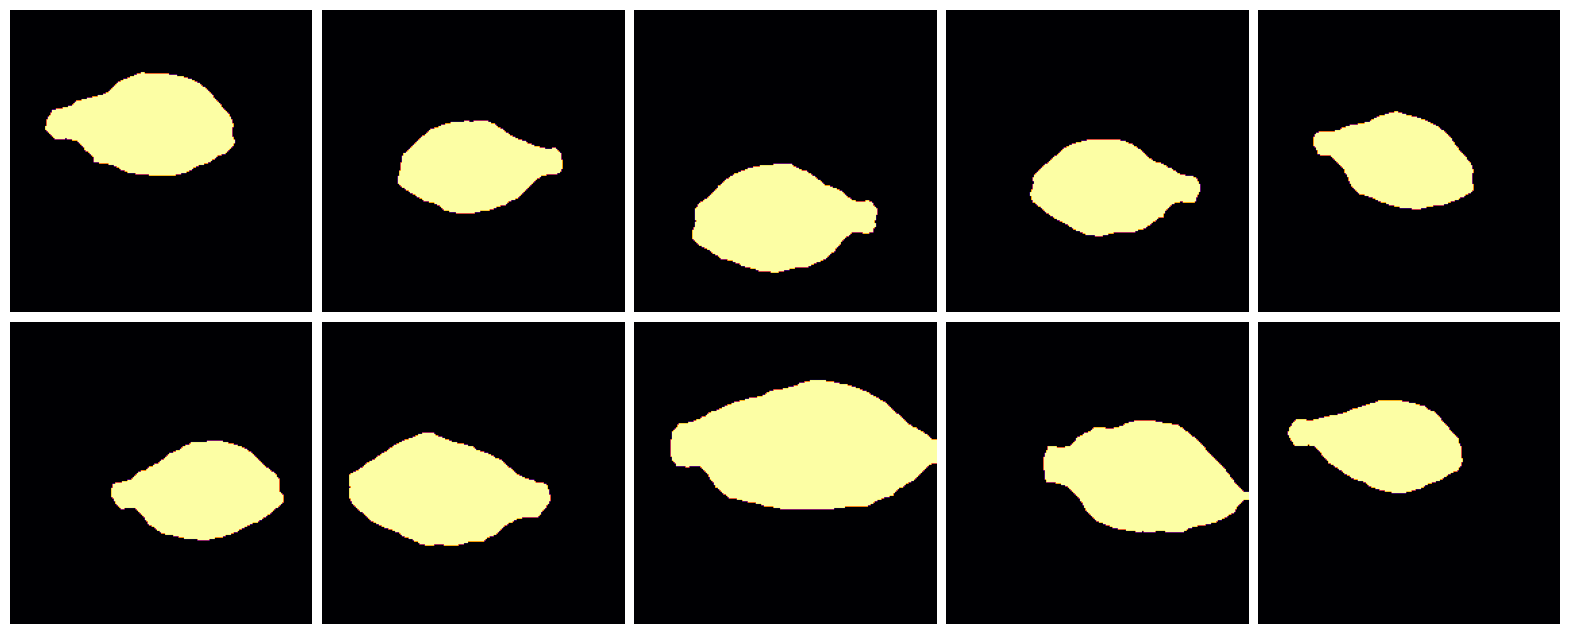

In [32]:
plot(smoothed_masks[:10], (2, 5))

In [39]:
extract_features_from_images(
    images_arr=smoothed_masks,
    images_path=images_paths,
    output_file_name="features_from_unet_predictions.csv",
    resize_shape=(DIM, DIM),
)

74it [00:00, 165.41it/s]
